In [57]:
import warnings 

import geopandas as gpd
import libpysal
import mapclassify
import matplotlib.pyplot as plt
import momepy as mm
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

from tqdm.auto import tqdm
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
from scipy.cluster import hierarchy
from clustergram import Clustergram
from bokeh.plotting import show

# we are using bleeding edge software that emits some warnings irrelevant for the current runtime
warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
warnings.filterwarnings('ignore', message='.*overflow encountered*')
warnings.filterwarnings('ignore', message='.*index_parts defaults to True')
warnings.filterwarnings('ignore', message='.*`op` parameter is deprecated*')

In [6]:
local_crs = 2154

### Buildings

In [7]:
# load data
buildings = gpd.read_parquet('./data/buildings.parquet')

In [8]:
# clean buildings
buildings = buildings[buildings.geom_type == "Polygon"].reset_index(drop=True)
buildings = buildings[["geometry"]].to_crs(local_crs)
buildings["uID"] = range(len(buildings))

<AxesSubplot:>

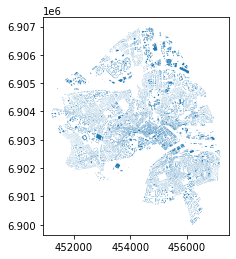

In [9]:
buildings.plot()

### Streets

In [11]:
streets = gpd.read_parquet('./data/streets.parquet')

### Tessellation

In [15]:
limit = mm.buffered_limit(buildings, 100)

tessellation = mm.Tessellation(buildings, "uID", limit, verbose=False, segment=1)
tessellation = tessellation.tessellation

c:\Users\b9066009\Anaconda3\envs\geo_env\lib\site-packages\momepy\elements.py:383: UserWarning: Tessellation does not fully match buildings. 103 element(s) collapsed during generation - unique_id: {10242, 25090, 4101, 4105, 9228, 5136, 4115, 8212, 4120, 5152, 7716, 12841, 15406, 22575, 13363, 5685, 7225, 5691, 16958, 10310, 1101, 12372, 16470, 9315, 12907, 10867, 11895, 7290, 10365, 5248, 17025, 7317, 9367, 7837, 4768, 12448, 8358, 11956, 14004, 6335, 8895, 5316, 10952, 8905, 11474, 5846, 4832, 6370, 9444, 15085, 9975, 9984, 11529, 9486, 8483, 5925, 7974, 5426, 11058, 23347, 6965, 6984, 4428, 11605, 8549, 9573, 14695, 25446, 5481, 25447, 25448, 18796, 25449, 25451, 12662, 9602, 12170, 11158, 11671, 6574, 5039, 5557, 12214, 12215, 22969, 5568, 22470, 22471, 22472, 22473, 22474, 22475, 26580, 7129, 7133, 9695, 26594, 26087, 4072, 6634, 4085, 5111, 4093}
  warnings.warn(
c:\Users\b9066009\Anaconda3\envs\geo_env\lib\site-packages\momepy\elements.py:394: UserWarning: Tessellation contains M

### Link streets


In [16]:
buildings = buildings.sjoin_nearest(streets, max_distance=1000, how="left")

In [17]:
buildings = buildings.drop_duplicates("uID").drop(columns="index_right")

In [18]:
tessellation = tessellation.merge(buildings[['uID', 'nID']], on='uID', how='left')

### Measure
#### Dimensions

In [19]:
buildings["area"] = buildings.area
tessellation["area"] = tessellation.area
streets["length"] = streets.length

#### Shape

In [20]:
buildings['eri'] = mm.EquivalentRectangularIndex(buildings).series
buildings['elongation'] = mm.Elongation(buildings).series
tessellation['convexity'] = mm.Convexity(tessellation).series
streets["linearity"] = mm.Linearity(streets).series

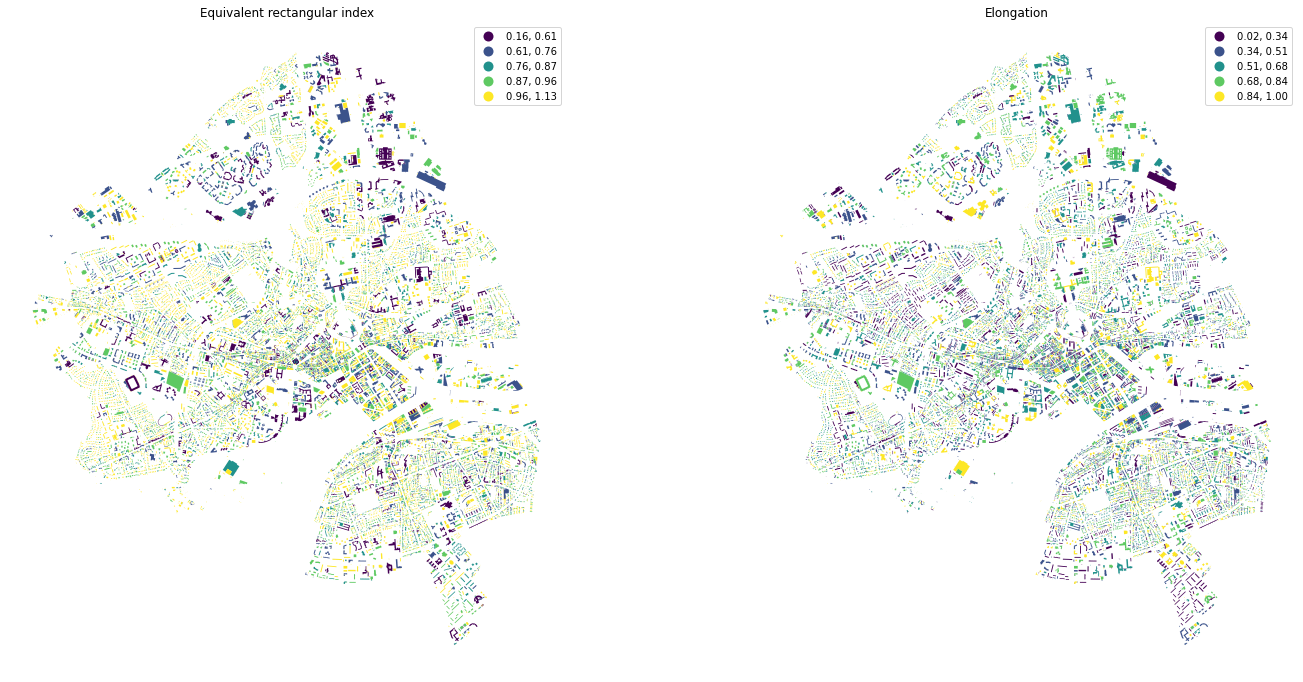

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("eri", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("elongation", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

ax[0].title.set_text('Equivalent rectangular index')
ax[1].title.set_text('Elongation')

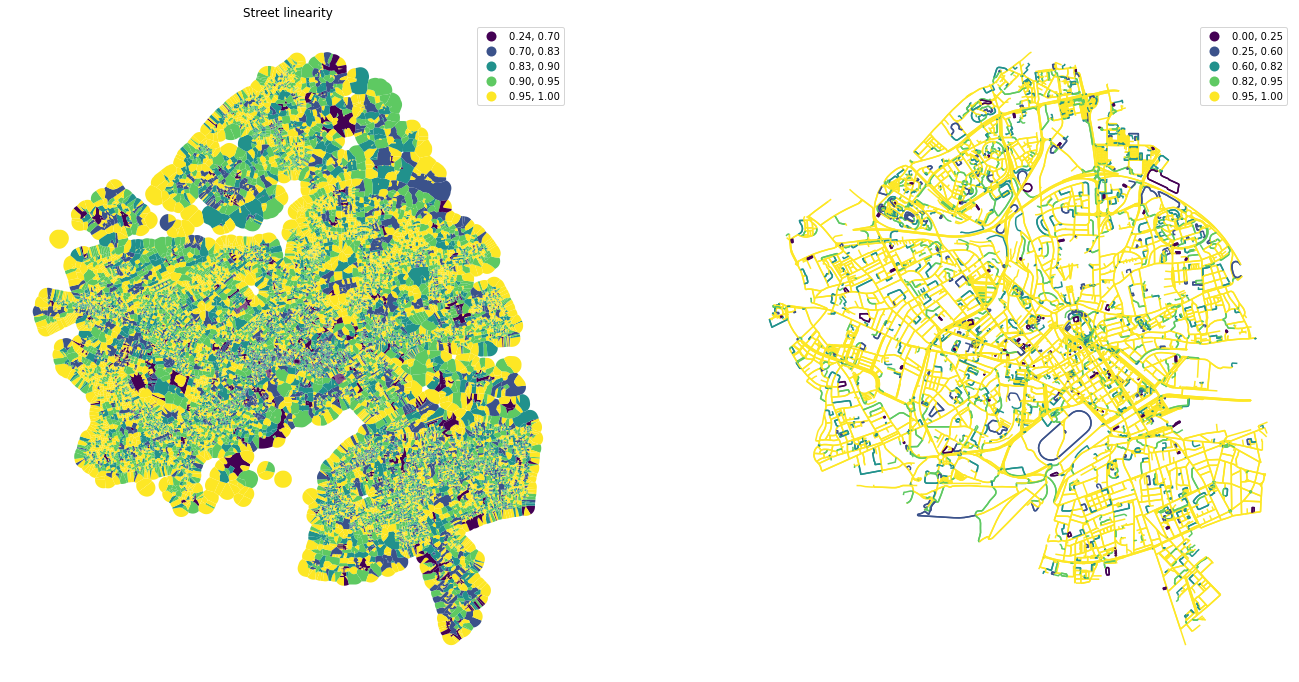

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("linearity", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

ax[0].title.set_text('Convexity')
ax[0].title.set_text('Street linearity')

#### Spatial distribution

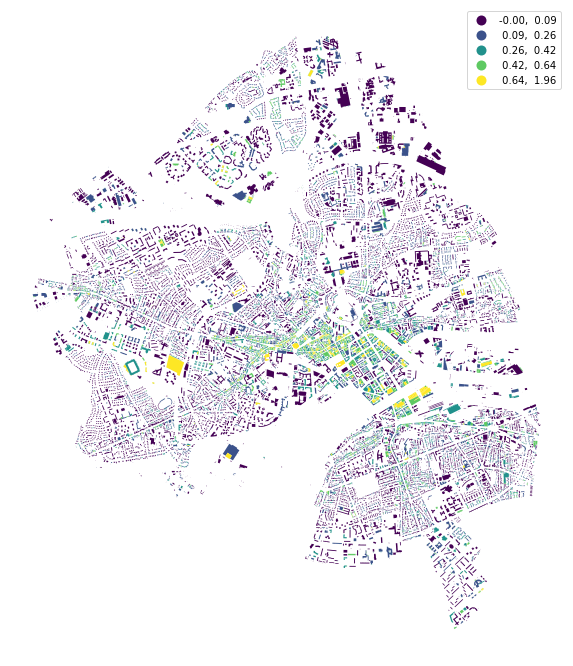

In [31]:
buildings["shared_walls"] = mm.SharedWallsRatio(buildings).series
buildings.plot("shared_walls", figsize=(12, 12), scheme="natural_breaks", legend=True).set_axis_off()

In [32]:
queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tessellation, ids="uID", silence_warnings=True)

In [34]:
tessellation["neighbors"] = mm.Neighbors(tessellation, queen_1, "uID", weighted=True, verbose=False).series
tessellation["covered_area"] = mm.CoveredArea(tessellation, queen_1, "uID", verbose=False).series

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    buildings["neighbor_distance"] = mm.NeighborDistance(buildings, queen_1, "uID", verbose=False).series

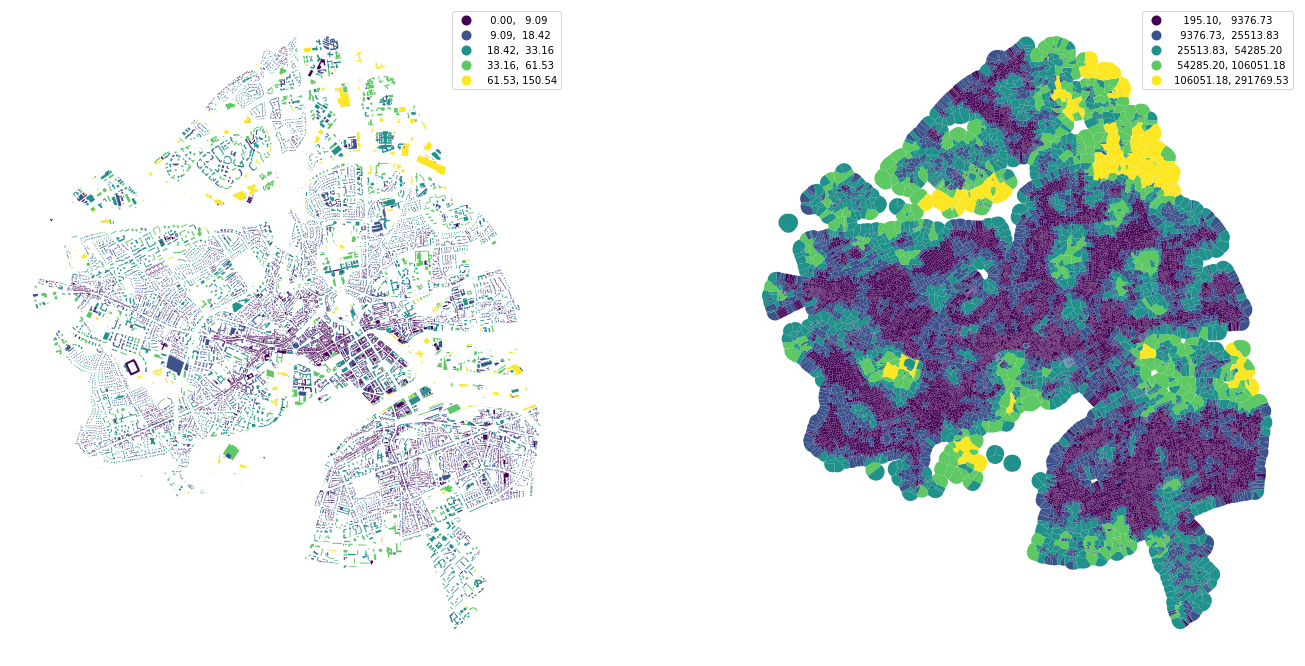

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("neighbor_distance", ax=ax[0], scheme="natural_breaks", legend=True)
tessellation.plot("covered_area", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

In [36]:
queen_3 = mm.sw_high(k=3, weights=queen_1)
buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)

buildings['interbuilding_distance'] = mm.MeanInterbuildingDistance(buildings, queen_1, 'uID', queen_3, verbose=False).series
buildings['adjacency'] = mm.BuildingAdjacency(buildings, queen_3, 'uID', buildings_q1, verbose=False).series

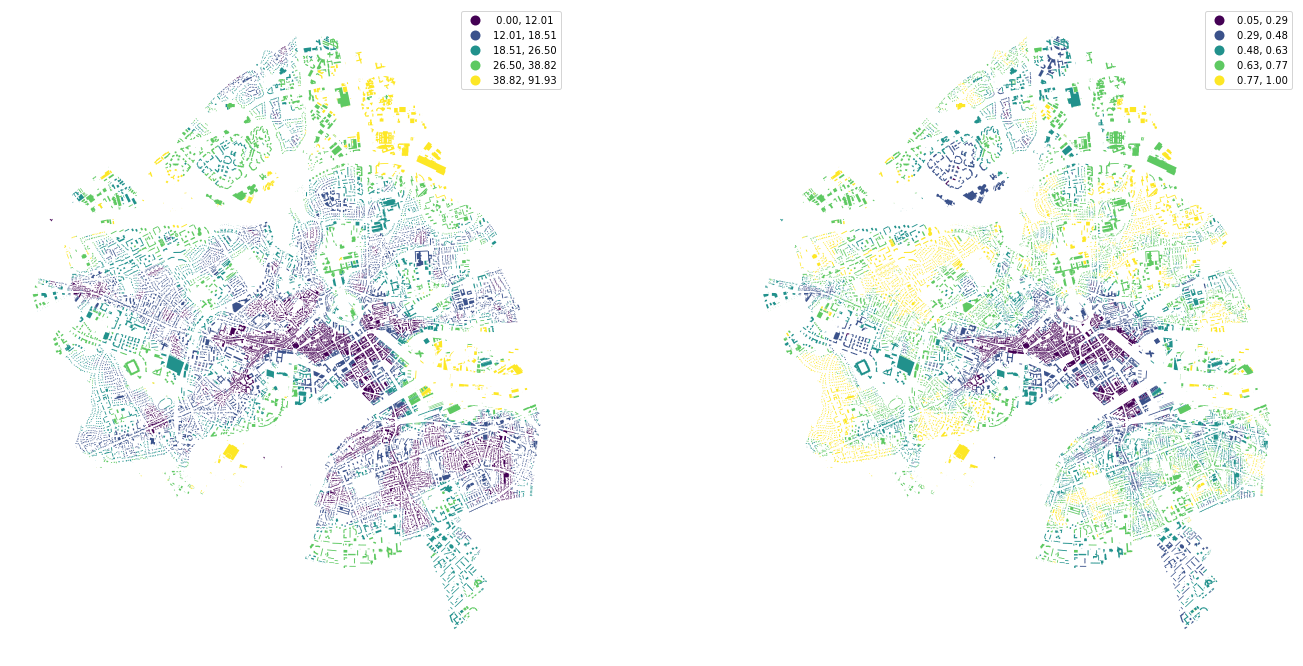

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("interbuilding_distance", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("adjacency", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

In [38]:
profile = mm.StreetProfile(streets, buildings)
streets["width"] = profile.w
streets["width_deviation"] = profile.wd
streets["openness"] = profile.o

c:\Users\b9066009\Anaconda3\envs\geo_env\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\b9066009\Anaconda3\envs\geo_env\lib\site-packages\momepy\dimension.py:641: RuntimeWarning: invalid value encountered in long_scalars
  openness.append(np.isnan(s).sum() / (f).sum())


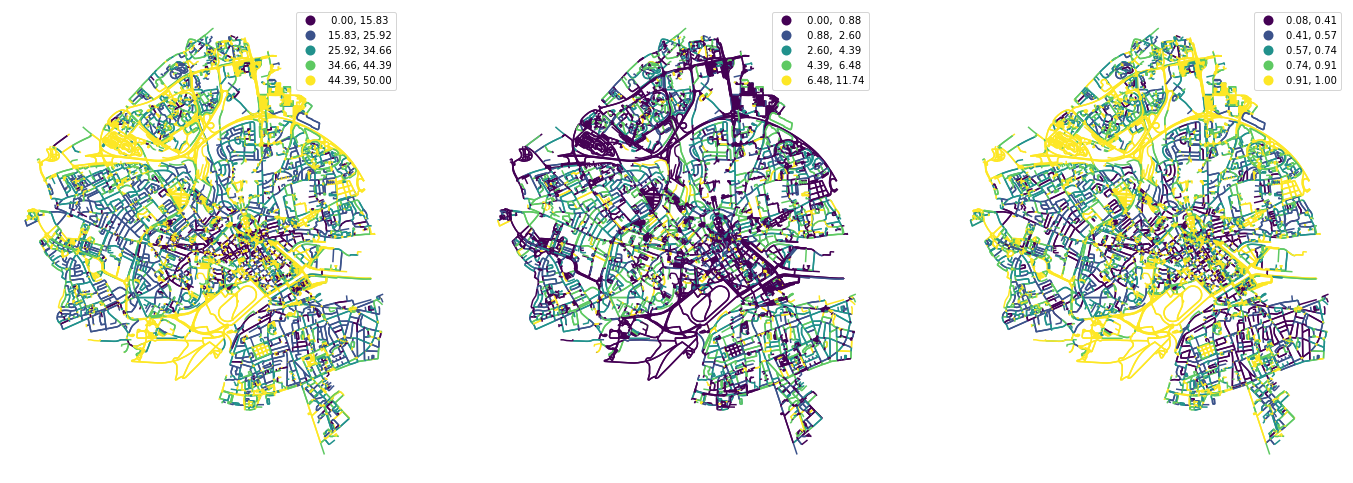

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

streets.plot("width", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("width_deviation", ax=ax[1], scheme="natural_breaks", legend=True)
streets.plot("openness", ax=ax[2], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

#### Intensity

In [40]:
tessellation['car'] = mm.AreaRatio(tessellation, buildings, 'area', 'area', 'uID').series

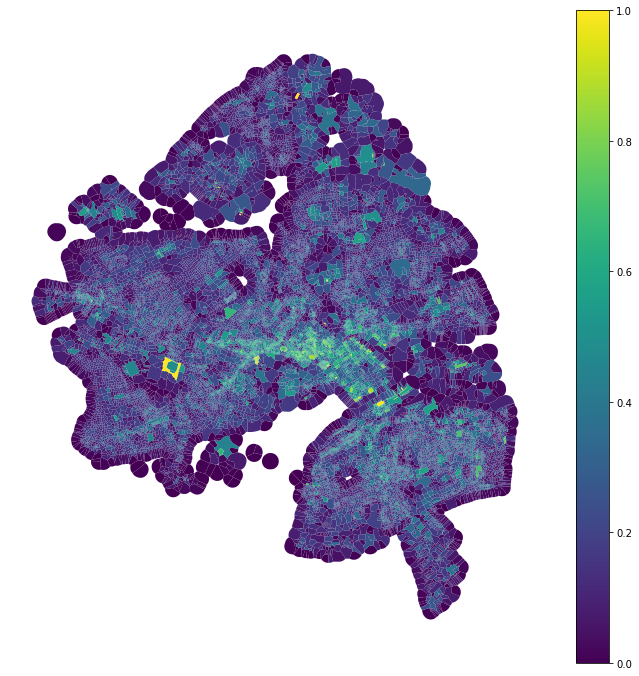

In [41]:

tessellation.plot("car", figsize=(12, 12), vmin=0, vmax=1, legend=True).set_axis_off()

#### Connectivity

In [42]:
graph = mm.gdf_to_nx(streets)

In [43]:
graph = mm.node_degree(graph)
graph = mm.closeness_centrality(graph, radius=400, distance="mm_len")
graph = mm.meshedness(graph, radius=400, distance="mm_len")

100%|██████████| 10696/10696 [02:19<00:00, 76.90it/s] 


In [44]:
nodes, streets = mm.nx_to_gdf(graph)

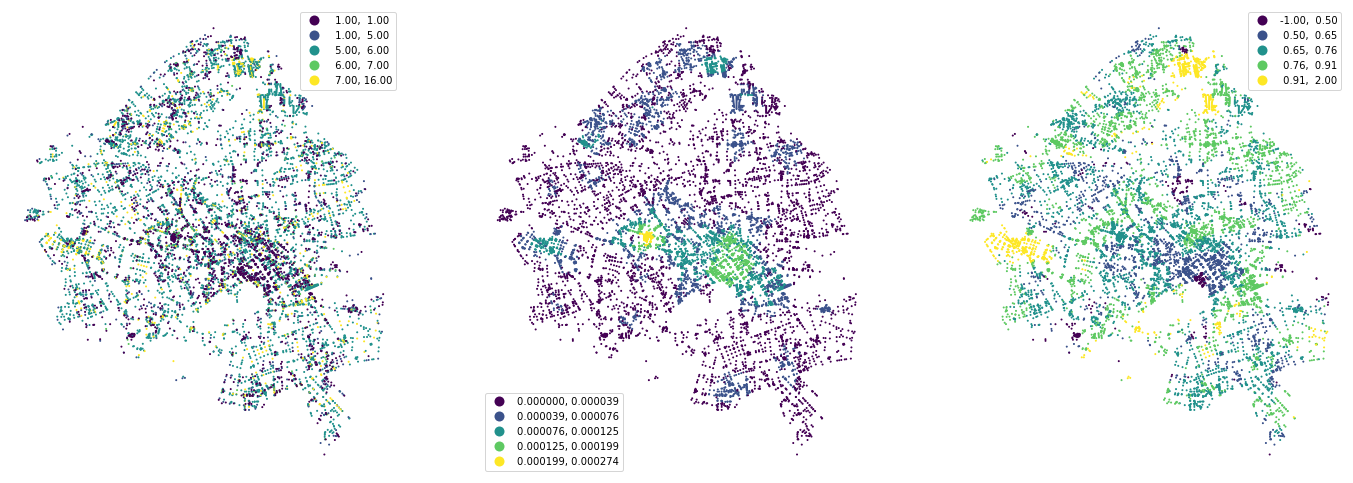

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

nodes.plot("degree", ax=ax[0], scheme="natural_breaks", legend=True, markersize=1)
nodes.plot("closeness", ax=ax[1], scheme="natural_breaks", legend=True, markersize=1, legend_kwds={"fmt": "{:.6f}"})
nodes.plot("meshedness", ax=ax[2], scheme="natural_breaks", legend=True, markersize=1)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

In [46]:
buildings["nodeID"] = mm.get_node_id(buildings, nodes, streets, "nodeID", "nID")

100%|██████████| 26917/26917 [00:16<00:00, 1672.75it/s]


Merge all the data together

In [47]:
merged = tessellation.merge(buildings.drop(columns=['nID', 'geometry']), on='uID')
merged = merged.merge(streets.drop(columns='geometry'), on='nID', how='left')
merged = merged.merge(nodes.drop(columns='geometry'), on='nodeID', how='left')

### Understanding the context
Measure first, second and third quartile of distribution of values within an area around each building.

In [49]:
percentiles = []
for column in merged.columns.drop(["uID", "nodeID", "nID", 'mm_len', 'node_start', 'node_end', "geometry"]):
    perc = mm.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
    perc.columns = [f"{column}_" + str(x) for x in perc.columns]
    percentiles.append(perc)

c:\Users\b9066009\Anaconda3\envs\geo_env\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
c:\Users\b9066009\Anaconda3\envs\geo_env\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


In [50]:
percentiles_joined = pd.concat(percentiles, axis=1)

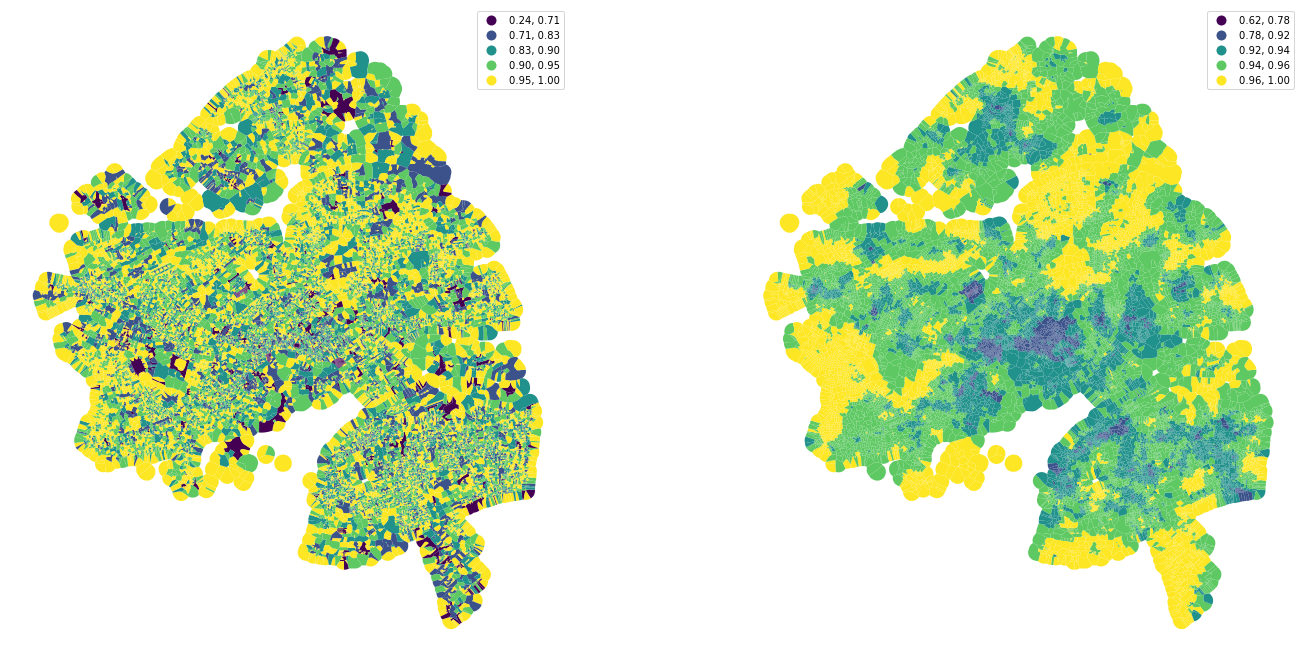

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
merged.plot(percentiles_joined['convexity_50'].values, ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

### Clustering

In [52]:
standardized = (percentiles_joined - percentiles_joined.mean()) / percentiles_joined.std()

#### How many clusters?

In [56]:
cgram = Clustergram(range(1, 12), n_init=10, random_state=0)
cgram.fit(standardized.fillna(0))

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.37935686111450195 seconds.
K=3 fitted in 0.41802000999450684 seconds.
K=4 fitted in 0.4584157466888428 seconds.
K=5 fitted in 0.9135558605194092 seconds.
K=6 fitted in 1.206993818283081 seconds.
K=7 fitted in 1.4216861724853516 seconds.
K=8 fitted in 1.683614730834961 seconds.
K=9 fitted in 2.245070219039917 seconds.
K=10 fitted in 2.373866081237793 seconds.
K=11 fitted in 3.0507888793945312 seconds.


In [58]:
show(cgram.bokeh())

In [59]:
cgram.labels.head()

1   2   3   4   5   6   7   8   9   10  11
0   0   0   1   2   0   1   5   2   0   1   9
1   0   0   1   2   0   1   5   2   0   1   9
2   0   0   1   2   0   1   5   2   0   1   9
3   0   0   1   2   0   1   5   2   0   1   9
4   0   0   1   2   0   1   5   2   0   1   9

In [60]:
merged["cluster"] = cgram.labels[8].values

In [61]:
urban_types = buildings[["geometry", "uID"]].merge(merged[["uID", "cluster"]], on="uID")

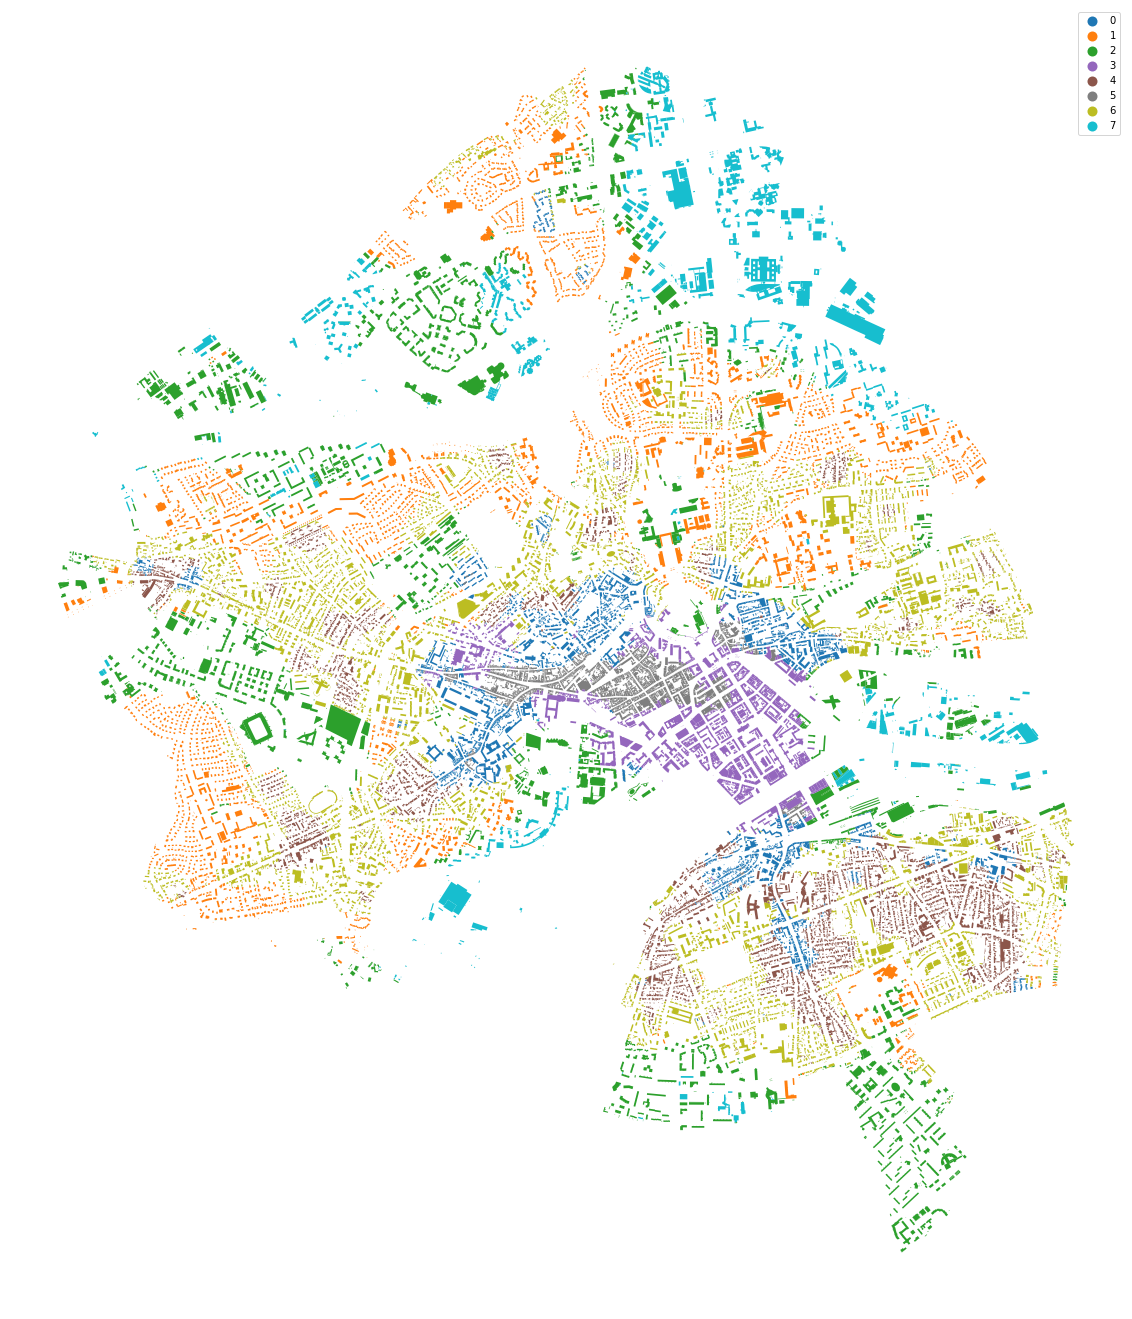

In [81]:
fig, ax = plt.subplots(1, figsize=(24, 24))

ax = urban_types.plot(column = 'cluster', ax=ax, categorical=True, legend=True)

ax.set_axis_off()